## ResNet

In [42]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/bfortuner/workplace/VisionQuest")
from common import *
import torchvision.models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

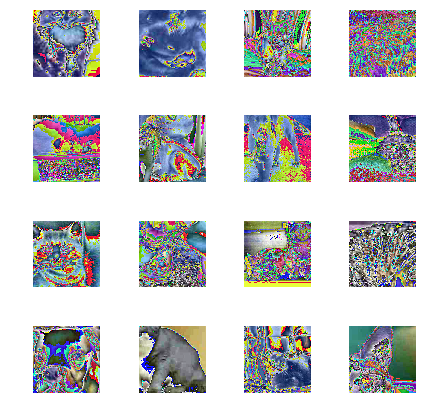

In [45]:
# Cats/Dogs
N_CLASSES = 2
IMG_DIR = '/bigguy/data/dogscats/train/'
train_loader, test_loader, classes = datasets.get_catsdogs_loader(IMG_DIR)
inputs,targets,img_paths = next(iter(train_loader))
utils.imgs.plot_rgb_samples(inputs)

## Model 

In [54]:
# Implementation from scratch
# https://arxiv.org/abs/1512.03385

## Pretrained

In [47]:
class SimpleResnet(nn.Module):
    def __init__(self, resnet, classifier):
        super().__init__()
        self.resnet = resnet
        self.classifier = classifier

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [50]:
resnet = utils.models.get_resnet18(pretrained=True, n_freeze=0)
resnet = utils.models.cut_model(resnet, -1)
classifier = utils.layers.get_mlp_classifier(
    512, 100, N_CLASSES, nn.Softmax(1), 0.01, 0.5)
model = SimpleResnet(resnet, classifier).cuda()

## Train

In [51]:
data = next(iter(train_loader))
inputs,targets = Variable(data[0].cuda()), Variable(data[1].cuda())
model(inputs).size()

torch.Size([32, 2])

In [52]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
lr_adjuster = learning_rates.FixedLR(initial_lr=1e-3, iteration_type='epoch')
trainer = training.QuickTrainer()
trainer.run(model, train_loader, test_loader, criterion, optimizer, epochs=5) 

Epoch 1, TrnLoss: 0.510, TrnAcc: 0.792, TstLoss: 0.416, TstAcc: 0.894
Epoch 2, TrnLoss: 0.482, TrnAcc: 0.823, TstLoss: 0.430, TstAcc: 0.875
Epoch 3, TrnLoss: 0.465, TrnAcc: 0.840, TstLoss: 0.417, TstAcc: 0.890
Epoch 4, TrnLoss: 0.447, TrnAcc: 0.858, TstLoss: 0.385, TstAcc: 0.925
Epoch 5, TrnLoss: 0.446, TrnAcc: 0.858, TstLoss: 0.384, TstAcc: 0.926


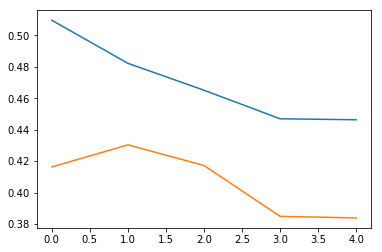

In [53]:
plt.plot(np.stack([trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst']],1))

## Export

In [ ]:
# Input to the model
x = Variable(torch.randn(1, 3, 224, 224), requires_grad=True)

# Export the model
torch_out = torch.onnx._export(model,
                               x, # model input (or a tuple for multiple inputs)
                               # where to save the model (can be a file or file-like object)
                               "resnet_imagenet.onnx", 
                                # store the trained parameter weights inside the model file
                               export_params=True)

## Sources

* Deep Residual Learning for Image Recognition https://arxiv.org/abs/1512.03385
* https://github.com/onnx/onnx-caffe2
* http://pytorch.org/tutorials/advanced/super_resolution_with_caffe2.html
* https://github.com/pytorch/pytorch#from-source
* https://github.com/pytorch/pytorch/issues/2898
* https://github.com/onnx/tutorials/blob/master/tutorials/PytorchAddExportSupport.md
* https://caffe2.ai/docs/getting-started.html?platform=ubuntu&configuration=compile
* https://github.com/google/protobuf/tree/master/python
* https://developers.google.com/protocol-buffers/